**Reinforcement Learning (RL) Experiment**

In [31]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
import packaging.version

In [32]:
# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

In [ ]:
# Check numpy version and provide a potential workaround
if packaging.version.parse(np.__version__) >= packaging.version.parse('2.0.0'):
    print("Warning: Numpy version 2.0.0 or higher detected. This may cause compatibility issues with gym.")
    # Workaround: Define bool8 if it doesn't exist
    if not hasattr(np, 'bool8'):
        np.bool8 = np.bool_ # Use np.bool_ as a fallback

In [35]:
# Hyperparameters
ENV_NAME = 'CartPole-v1'
EPISODES = 500
LEARNING_RATE = 0.001
GAMMA = 0.99
EPSILON_START = 1.0
EPSILON_MIN = 0.01
EPSILON_DECAY = 0.995
BATCH_SIZE = 64
MEMORY_SIZE = 10000
TARGET_UPDATE = 10


In [36]:
# Environment setup
env = gym.make(ENV_NAME)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

In [37]:
# DQN model
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 24)
        self.fc2 = nn.Linear(24, 24)
        self.output = nn.Linear(24, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.output(x)

In [38]:
# Initialize networks
policy_net = DQN(state_size, action_size)
target_net = DQN(state_size, action_size)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()
memory = deque(maxlen=MEMORY_SIZE)

In [39]:
# Epsilon-greedy action selection
def select_action(state, epsilon):
    if random.random() < epsilon:
        return random.randrange(action_size)
    else:
        with torch.no_grad():
            state = torch.FloatTensor(state)
            q_values = policy_net(state)
            return q_values.argmax().item()

In [40]:
# Training function
def train_step():
    if len(memory) < BATCH_SIZE:
        return

    batch = random.sample(memory, BATCH_SIZE)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.FloatTensor(states)
    actions = torch.LongTensor(actions).unsqueeze(1)
    rewards = torch.FloatTensor(rewards)
    next_states = torch.FloatTensor(next_states)
    dones = torch.FloatTensor(dones)

    q_values = policy_net(states).gather(1, actions).squeeze()
    next_q_values = target_net(next_states).max(1)[0]
    target_q = rewards + (GAMMA * next_q_values * (1 - dones))

    loss = criterion(q_values, target_q.detach())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
# Training loop
epsilon = EPSILON_START
rewards_per_episode = []

for episode in range(EPISODES):
    state = env.reset()[0]  # For gym>=0.26
    total_reward = 0

    done = False
    while not done:
        action = select_action(state, epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        memory.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward
        train_step()

    rewards_per_episode.append(total_reward)
    epsilon = max(EPSILON_MIN, epsilon * EPSILON_DECAY)

    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    if episode % 10 == 0:
        print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}")

Episode 0, Total Reward: 10.0, Epsilon: 0.995
Episode 10, Total Reward: 30.0, Epsilon: 0.946
Episode 20, Total Reward: 11.0, Epsilon: 0.900
Episode 30, Total Reward: 15.0, Epsilon: 0.856
Episode 40, Total Reward: 13.0, Epsilon: 0.814
Episode 50, Total Reward: 31.0, Epsilon: 0.774
Episode 60, Total Reward: 21.0, Epsilon: 0.737
Episode 70, Total Reward: 52.0, Epsilon: 0.701
Episode 80, Total Reward: 59.0, Epsilon: 0.666
Episode 90, Total Reward: 42.0, Epsilon: 0.634
Episode 100, Total Reward: 31.0, Epsilon: 0.603
Episode 110, Total Reward: 114.0, Epsilon: 0.573
Episode 120, Total Reward: 149.0, Epsilon: 0.545
Episode 130, Total Reward: 203.0, Epsilon: 0.519
Episode 140, Total Reward: 16.0, Epsilon: 0.493
Episode 150, Total Reward: 40.0, Epsilon: 0.469
Episode 160, Total Reward: 138.0, Epsilon: 0.446
Episode 170, Total Reward: 196.0, Epsilon: 0.424
Episode 180, Total Reward: 179.0, Epsilon: 0.404
Episode 190, Total Reward: 79.0, Epsilon: 0.384
Episode 200, Total Reward: 116.0, Epsilon: 0.

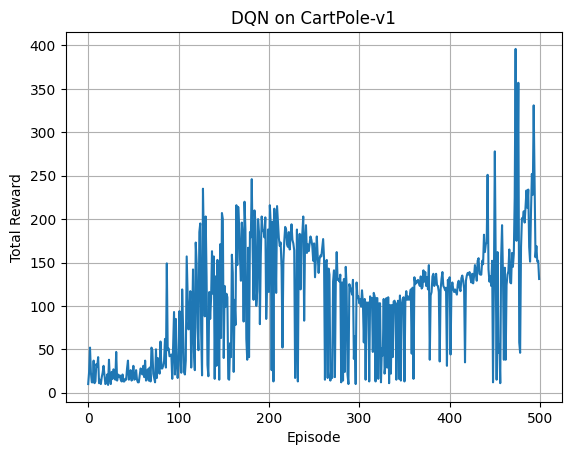

In [41]:
# Plot the rewards
plt.plot(rewards_per_episode)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN on CartPole-v1")
plt.grid()
plt.show()